## Inference script 
- frame to video 
- video to frame 

## steps 
- process audio files 
- store all the frames in a folder 
- generate use mediapipe landmarks 
- we will get bbox for each frame for the corresponding N frames [-2+2]
- select the mega box to fit human in it 
- crop all the frames according to mega box and resize it to 256x256 
- rearrange all bboxes to mega box and resize them to 256x256 
- Now pick each frame & crop using bbox of that frame, predict and restore it to the original frame
- merge frames and create a video by adding audio 

In [1]:
import cv2 
import numpy as np
import fastcore.all as fc
from lipsync.create_ds.video_utils import extract_frames
from lipsync.hallo_audio.audio_processor import AudioProcessor
from lipsync.create_ds.mediapipe_landmarks import FaceLandmarks
from lipsync.inference.silero import get_silence_detector
from lipsync.create_ds.face_mask import get_face_mask, get_union_mask, mask2bbox, make_square_bbox, get_union_bbox
from tqdm import tqdm
from PIL import Image
from moviepy import ImageClip, concatenate_videoclips, AudioFileClip

import matplotlib.pyplot as plt
plt.style.use("bmh")
%matplotlib inline

In [2]:
video_path = "../weights/data/anshul3-source_25fps_numbered.mp4"
#video_path = "videos/ad_input/shot5.mov"
#audio_path = "videos/ad_input/male_new.mp3"
audio_path = "../weights/data/anshul-driving-audio-02mins.mp3"
#video_path = "/home/prakash/lipsync/weights/gen/jenny-ai-front_25fps.mp4"
#audio_path = "/home/prakash/lipsync/weights/gen/emotional_audio.mp3"

In [3]:
def with_opencv(video_path):
    video = cv2.VideoCapture(video_path)
    if not video.isOpened():
        print("Error: Could not open video.")
        return None
    else:
        fps = video.get(cv2.CAP_PROP_FPS)
        total_frames = video.get(cv2.CAP_PROP_FRAME_COUNT)
        width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    video.release()
    return fps, total_frames, (height, width)

fps, total_frames, (height, width) = with_opencv(video_path)
fps, total_frames, (height, width)

(25.0, 3045.0, (1080, 1920))

## Process audio 

In [4]:
audio_processor = AudioProcessor(
        16000, 25, "facebook/wav2vec2-base-960h", False, None, None, device="cpu"
    )
audio_emb, _ = audio_processor.preprocess(audio_path)
wav2vec = audio_emb.cpu().numpy()
res_frame_length_based_on_audio = wav2vec.shape[0]
wav2vec.shape, res_frame_length_based_on_audio


Some weights of Wav2VecModel were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


((3004, 12, 768), 3004)

In [5]:
silence_detector = get_silence_detector()
silence_regions = silence_detector.detect_silence(audio_path)
silence_frames = [
    (round(start * fps), round(end * fps))
    for start, end in silence_regions
]
silence_frames

Using cache found in /home/prakash/.cache/torch/hub/snakers4_silero-vad_master


[(0, 22),
 (245, 265),
 (368, 392),
 (510, 532),
 (630, 642),
 (895, 995),
 (1168, 1330),
 (1492, 1508),
 (1645, 1658),
 (1742, 1755),
 (1995, 2012),
 (2025, 2048),
 (2088, 2100),
 (2120, 2140),
 (2238, 2258),
 (2370, 2392),
 (2485, 2502),
 (2532, 2550),
 (2602, 2615),
 (2740, 2755),
 (2798, 2870),
 (2985, 3004)]

In [6]:
silences = np.zeros(wav2vec.shape[0])
for s in silence_frames:
    silences[s[0]:s[1]] = 1
silences.shape

(3004,)

In [7]:
#pad the audio as 1st frame need 2 before frames and last frame need 2 after frames
wav2vec_feature_padding = np.pad(wav2vec, ((2, 2), (0, 0), (0, 0)), mode='edge')
silence_padding = np.pad(silences, ((2, 2),), mode='edge')
wav2vec_feature_padding.shape, silence_padding.shape

((3008, 12, 768), (3008,))

## Extract frames 

In [8]:
frames_path = fc.Path("assets/frames")
if not frames_path.exists():
    end_number = res_frame_length_based_on_audio if res_frame_length_based_on_audio < total_frames else total_frames
    extract_frames(video_path, "assets/frames/", start_number=0, step=1, end_number=end_number)
video_frame_path_list = fc.L(fc.Path("assets/frames/").glob("*.png"))
video_frame_path_list.sort()
video_frame_path_list

(#3004) [Path('assets/frames/000000.png'),Path('assets/frames/000001.png'),Path('assets/frames/000002.png'),Path('assets/frames/000003.png'),Path('assets/frames/000004.png'),Path('assets/frames/000005.png'),Path('assets/frames/000006.png'),Path('assets/frames/000007.png'),Path('assets/frames/000008.png'),Path('assets/frames/000009.png')...]

## Extract landmarks 

In [9]:
fl = FaceLandmarks("../weights/face_landmarker.task")
landmarks_save_path = fc.Path("assets/landmarks.npz")
if not fc.Path(landmarks_save_path).exists():
    face_landmarks, hw, frame_numbers = fl.process_frames(video_frame_path_list)
    np.savez(landmarks_save_path, face_landmarks=face_landmarks, hw=hw, frame_numbers=frame_numbers)
else:
    data = np.load(landmarks_save_path, allow_pickle=True)
    face_landmarks, hw, frame_numbers = data["face_landmarks"], data["hw"], data["frame_numbers"]
face_landmarks.shape, hw.shape, frame_numbers.shape

((3004, 478, 2), (3004, 2), (3004,))

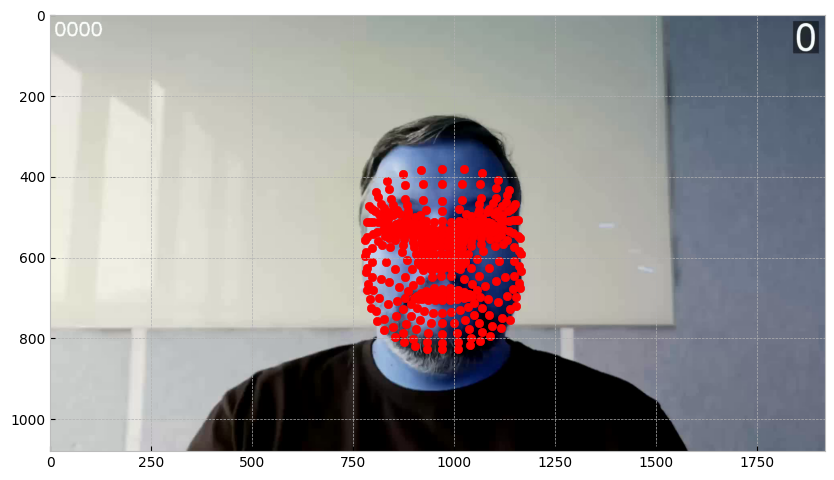

In [10]:
#visualize the landmarks on one frame 
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(cv2.imread(str(video_frame_path_list[0])))
ax.scatter(face_landmarks[0, :, 0], face_landmarks[0, :, 1], c="r")
plt.show()

In [11]:
video_frame_path_list_cycle = video_frame_path_list + video_frame_path_list[::-1]
frame_numbers_cycle = np.concatenate([frame_numbers, frame_numbers[::-1]], 0).tolist()
len(video_frame_path_list_cycle), len(frame_numbers_cycle)

(6008, 6008)

In [12]:
video_landmark_data_cycle = np.concatenate([face_landmarks, np.flip(face_landmarks, 0)], 0)
video_landmark_data_cycle.shape

(6008, 478, 2)

In [13]:
video_frame_path_list_cycle_length = len(video_frame_path_list_cycle)
video_frame_path_list_cycle_length

6008

In [14]:
if video_frame_path_list_cycle_length >= res_frame_length_based_on_audio:
    res_video_frame_path_list = video_frame_path_list_cycle[:res_frame_length_based_on_audio]
    res_video_frame_numbers = frame_numbers_cycle[:res_frame_length_based_on_audio]
    res_video_landmark_data = video_landmark_data_cycle[:res_frame_length_based_on_audio, :, :]
else:
    divisor = res_frame_length_based_on_audio // video_frame_path_list_cycle_length
    remainder = res_frame_length_based_on_audio % video_frame_path_list_cycle_length
    res_video_frame_path_list = video_frame_path_list_cycle * divisor + video_frame_path_list_cycle[:remainder]
    res_video_frame_numbers = frame_numbers_cycle * divisor + frame_numbers_cycle[:remainder]
    res_video_landmark_data = np.concatenate([video_landmark_data_cycle]* divisor + [video_landmark_data_cycle[:remainder, :, :]],0)

len(res_video_frame_path_list), res_video_landmark_data.shape, len(res_video_frame_numbers)

(3004, (3004, 478, 2), 3004)

In [15]:
face_landmarks_padded = np.pad(res_video_landmark_data, ((2, 2), (0, 0), (0, 0)), mode='edge')
face_landmarks_padded.shape

(3008, 478, 2)

In [16]:
face_landmarks_padded.shape, len(res_video_frame_numbers), wav2vec_feature_padding.shape, silence_padding.shape

((3008, 478, 2), 3004, (3008, 12, 768), (3008,))

## get bbox for each frame 

In [17]:
bboxes = []
batch_length = 1
for i in tqdm(range(len(res_video_frame_numbers))): 
    _landmarks = face_landmarks_padded[i:i+batch_length]
    #print(frame_numbers_req[i], _landmarks.shape)
    face_masks = []
    for _l in _landmarks: 
        face_mask, _ = get_face_mask(_l, height, width, expand_ratio=2.3)
        face_masks.append(face_mask)
    
    face_mask = get_union_mask(face_masks)
    face_valid, bbox = make_square_bbox(mask2bbox(face_mask), height, width)
    if not face_valid:
        bboxes.append([0, 0, 0, 0]+[res_video_frame_numbers[i]]+[-1])
        continue 
    bboxes.append(bbox+[res_video_frame_numbers[i]]+[1])

bboxes = np.asarray(bboxes)
print(bboxes.shape)
bboxes

100%|██████████| 3004/3004 [00:02<00:00, 1257.46it/s]

(3004, 6)


array([[ 531,  143, 1413, 1025,    0,    1],
       [ 531,  143, 1413, 1025,    1,    1],
       [ 531,  143, 1413, 1025,    2,    1],
       ...,
       [ 499,   98, 1437, 1036, 3001,    1],
       [ 501,  100, 1441, 1040, 3002,    1],
       [ 502,   95, 1442, 1035, 3003,    1]])

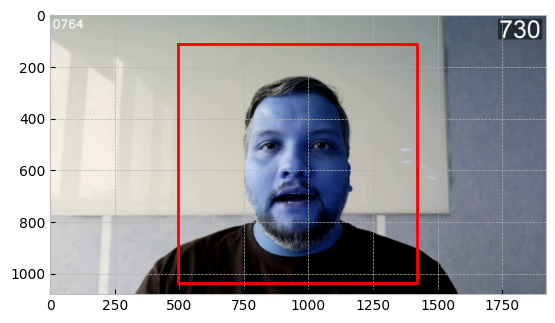

In [18]:
#visualize a frame with bbox    
t = np.random.randint(0, bboxes.shape[0])
x1, y1, x2, y2, frame_number, valid = bboxes[t]
img = cv2.imread(str(fc.Path("assets/frames/")/f"{frame_number:06d}.png"))
plt.imshow(img)
plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], c="r")
plt.show()


In [19]:
def is_bbox_within_image(bbox, height, width):
    min_x, min_y, max_x, max_y = bbox
    return min_x >= 0 and min_y >= 0 and max_x <= width and max_y <= height

def make_large_square_bbox(bbox, height, width):
    min_x, min_y, max_x, max_y = bbox
    size = max(max_x-min_x, max_y-min_y)
    ctr_x = (max_x + min_x) // 2
    ctr_y = (max_y + min_y) // 2
    radius = size // 2
    out = [ctr_x-radius, ctr_y-radius, ctr_x+radius, ctr_y+radius]
    return is_bbox_within_image(out, height, width), out

In [20]:
valid, mega_bbox = make_square_bbox(get_union_bbox(bboxes[:, :4]), height, width)
mega_bbox, valid

([470, 78, 1442, 1050], True)

In [21]:
# check if each bbox is within the mega bbox 
c1 = np.vstack([bboxes[:, 0] >= mega_bbox[0], bboxes[:, 1] >= mega_bbox[1], bboxes[:, 2] <= mega_bbox[2], bboxes[:, 3] <= mega_bbox[3]]).T
c2 = c1.sum(1)
bboxes[c2<4].shape


(66, 6)

In [22]:
valid, mega_bbox = make_large_square_bbox(get_union_bbox(bboxes[:, :4]), height, width)
mega_bbox, valid


([464, 72, 1448, 1056], True)

In [23]:
# if any side is negative, make it positive and check for how to pad the image  
pad_x1 = 0 if mega_bbox[0] >= 0 else -mega_bbox[0]
pad_y1 = 0 if mega_bbox[1] >= 0 else -mega_bbox[1]
pad_x2 = 0 if mega_bbox[2] <= width else mega_bbox[2]-width
pad_y2 = 0 if mega_bbox[3] <= height else mega_bbox[3]-height
pad_x1, pad_y1, pad_x2, pad_y2
pad = [pad_x1, pad_y1, pad_x2, pad_y2]
pad

[0, 0, 0, 0]

In [24]:
mega_bbox = [mega_bbox[0]+pad[0], mega_bbox[1]+pad[1], mega_bbox[2]+pad[2], mega_bbox[3]+pad[3]]
mega_bbox


[464, 72, 1448, 1056]

In [25]:
def resize_bbox(bbox, req_height, req_width, actual_height, actual_width):
    x1 = (bbox[0]/actual_width)*req_width
    y1 = (bbox[1]/actual_height)*req_height
    x2 = (bbox[2]/actual_width)*req_width
    y2 = (bbox[3]/actual_height)*req_height
    return x1, y1, x2, y2


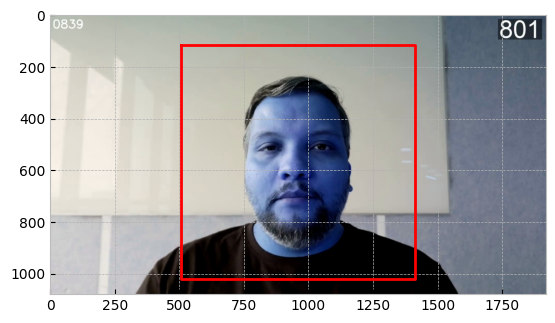

In [26]:
#visuzlize a frame and its bbox 
t = np.random.randint(0, bboxes.shape[0])
x1, y1, x2, y2, frame_number, valid = bboxes[t]
img = cv2.imread(str(fc.Path("assets/frames/")/f"{frame_number:06d}.png"))
plt.imshow(img)
plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], c="r")
plt.show()

## Load the model 

In [27]:
import torch
from lipsync.dinet.model import DINetSPADE

source_channel = 3
ref_channel = 15
ckpt_path = "/disk/prakash_training_weights/weights/v10/epoch=41-step=143262-val_ep_loss=1.113-train_ep_loss=1.068-val_ep_sync_loss=0.105-train_ep_sync_loss=0.170.ckpt"
model = DINetSPADE(source_channel, ref_channel, upscale=2, seg_face=True).cuda()
model.segface.model.to("cuda")
ckpt = torch.load(ckpt_path, map_location="cpu")
print(ckpt.keys())
ckpt_netg = {k[6:]: v for k, v in ckpt["state_dict"].items() if k.startswith("net_g.")}
model.load_state_dict(ckpt_netg)
model.eval()
print("eval mode set")

/tmp/ipykernel_3048317/838605233.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu")


dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers'])
eval mode set


## Get reference frames 

In [28]:
ref_index = np.random.randint(0, bboxes.shape[0], 5)
ref_index

array([ 170,  121,  488, 1999, 1919])

In [29]:
import torchvision
ref_frames_crop = []
for i in ref_index:
    x1, y1, x2, y2, frame_number, valid = bboxes[i]
    pimg = cv2.imread(str(fc.Path("assets/frames/")/f"{frame_number:06d}.png"))[:, :, ::-1]
    ref_frame = pimg[y1:y2, x1:x2]
    ref_frame = cv2.resize(ref_frame, (512, 512))
    ratio_x = ref_frame.shape[1]/512
    ratio_y = ref_frame.shape[0]/512
    ref_frame = torch.from_numpy(cv2.resize(ref_frame, (256, 256))).permute(2, 0, 1).cuda()
    ratio_x, ratio_y = 512/256, 512/256
    # Add color jitter and other transformations    
    #ref_frame = torchvision.transforms.v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)(ref_frame)
    ref_frames_crop.append(ref_frame)
ref_frames_crop = torch.vstack(ref_frames_crop)/255.0
ref_frames_crop.shape


torch.Size([15, 256, 256])

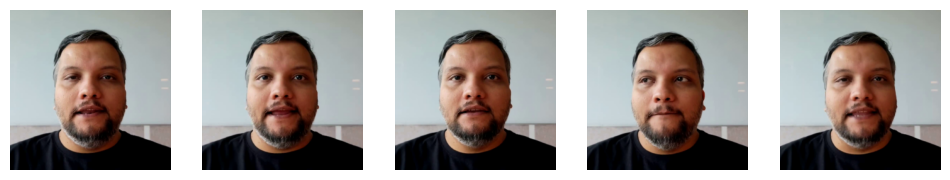

In [30]:
import torchvision
img1 = ref_frames_crop[0:3]
img2 = ref_frames_crop[3:6]
img3 = ref_frames_crop[6:9]
img4 = ref_frames_crop[9:12]
img5 = ref_frames_crop[12:15]
out = []
for img in [img1, img2, img3, img4, img5]:
    out.append(torchvision.transforms.ToPILImage()(img))


fig, ax = plt.subplots(figsize=(12, 3), nrows=1, ncols=len(out))
for n, i in enumerate(out):
    ax.flat[n].imshow(i)
    ax.flat[n].axis("off")
plt.show()

In [32]:
import torch.nn.functional as F
storage_path = fc.Path("assets/storage_fixed_ref_frames")
if not storage_path.exists():
    storage_path.mkdir()

for n, i in tqdm(enumerate(bboxes)):
    #if n!=222: continue 
    x1, y1, x2, y2, frame_number, valid = i 
    mask_dim=[64, 112, 192, 240]

    
    img = torchvision.io.read_image(str(fc.Path("assets/frames/")/f"{frame_number:06d}.png"))
    fimgx = img[:, y1:y2, x1:x2]        
    fimgx = torchvision.transforms.functional.resize(fimgx, (512, 512),)
    fimgx = F.interpolate(fimgx.unsqueeze(0), scale_factor=1/2, mode="bilinear")
    audio_emb = torch.from_numpy(wav2vec_feature_padding[n:n+5]).cuda().to(torch.float32)
    with torch.no_grad():
        ref_frames_crop[0:3] = fimgx[0]/255.0
        face_out = model(fimgx.cuda()/255.0, ref_frames_crop.unsqueeze(0), audio_emb.unsqueeze(0), mask_dim=mask_dim)
    
    out = face_out[0].permute(1, 2, 0).detach().cpu().numpy()
    img = img.permute(1, 2, 0).detach().cpu().numpy()
    img[y1:y2, x1:x2] = cv2.resize((np.uint8(out*255)), (y2-y1, x2-x1))
    save_img = cv2.resize(img[mega_bbox[1]:mega_bbox[3], mega_bbox[0]:mega_bbox[2]], (512, 512))
    Image.fromarray(save_img).save(storage_path/f"{n:06d}.png")

467it [01:26,  5.12it/s]

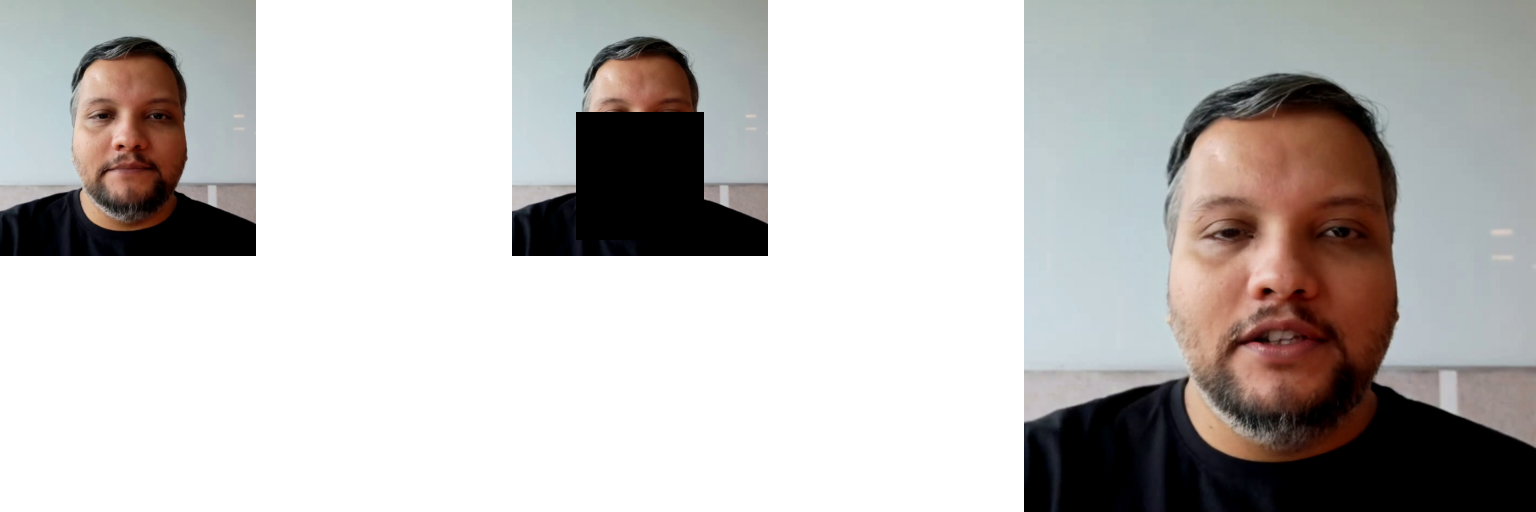

In [33]:
fimg_mask = fimgx[0].clone()
mask_dim = [64, 112, 192, 240]
fimg_mask[ :, mask_dim[1]:mask_dim[3], mask_dim[0]:mask_dim[2]] = 0
x1 = torchvision.transforms.ToPILImage()(fimgx[0])
x2 = torchvision.transforms.ToPILImage()(fimg_mask)
x3 = Image.fromarray(np.uint8(out*255))

#concatenate pil images in a grid  
x = Image.new("RGB", (512*3, 512), (255, 255, 255))
x.paste(x1, (0, 0))
x.paste(x2, (512, 0))
x.paste(x3, (1024, 0))
x

In [34]:
stored_files = fc.L(storage_path.glob("*.png"))
stored_files.sort()
stored_files

(#3004) [Path('assets/storage_fixed_ref_frames/000000.png'),Path('assets/storage_fixed_ref_frames/000001.png'),Path('assets/storage_fixed_ref_frames/000002.png'),Path('assets/storage_fixed_ref_frames/000003.png'),Path('assets/storage_fixed_ref_frames/000004.png'),Path('assets/storage_fixed_ref_frames/000005.png'),Path('assets/storage_fixed_ref_frames/000006.png'),Path('assets/storage_fixed_ref_frames/000007.png'),Path('assets/storage_fixed_ref_frames/000008.png'),Path('assets/storage_fixed_ref_frames/000009.png')...]

In [35]:
from moviepy import CompositeVideoClip
def frames_to_video(image_files, audio_path, output_path, fps=25):
    clips = [ImageClip(str(m), duration=1/fps) for m in image_files]
    video = concatenate_videoclips(clips, method="compose")

    audio = AudioFileClip(audio_path)
    final_video = CompositeVideoClip([video])
    final_video.audio = audio
    final_video.write_videofile(output_path, fps=fps, codec='libx264', audio_codec='aac')

In [36]:
frames_to_video(stored_files, audio_path, "assets/v10_1st_rf_dynamic_512.mp4")


MoviePy - Building video assets/v10_res_face_moviepy_silence_ref_frames_for_silence_512.mp4.
MoviePy - Writing audio in v10_res_face_moviepy_silence_ref_frames_for_silence_512TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
MoviePy - Writing video assets/v10_res_face_moviepy_silence_ref_frames_for_silence_512.mp4



MoviePy - Done !
MoviePy - video ready assets/v10_res_face_moviepy_silence_ref_frames_for_silence_512.mp4
